# LAB 3.2 - CNS (ESN)

Import of libraries and fix of random seed.


In [1]:
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from typing import Callable
from tqdm.notebook import tqdm
import pickle

seed = 0
random.seed(seed)
np.random.seed(seed)

Loading of dataset NARMA10.

In [2]:
with open(f'NARMA10.csv') as file:
    data = file.read().split('\n')[:-1]
    X_narma10 = np.array([float(r) for r in data[0].split(',')])
    Y_narma10 = np.array([float(r) for r in data[1].split(',')])

X_narma10.shape, Y_narma10.shape

((10000,), (10000,))

Split in train and test set for each X and Y data.

In [3]:
tr_size = 5000

TR_X_narma10 = X_narma10[:tr_size].reshape(-1, 1, 1)
TR_Y_narma10 = Y_narma10[:tr_size].reshape(-1, 1)
TS_X_narma10 = X_narma10[tr_size:].reshape(-1, 1, 1)
TS_Y_narma10 = Y_narma10[tr_size:].reshape(-1, 1)

TR_X_narma10.shape, TR_Y_narma10.shape, TS_X_narma10.shape, TS_Y_narma10.shape

((5000, 1, 1), (5000, 1), (5000, 1, 1), (5000, 1))

Functions able to provide an easiest way to plot the results.

In [4]:
def _base_plot(
        elements: list[tuple],
        title: str = '',
        xlabel: str = '',
        ylabel: str = '',
        xscale=None,
        yscale=None,
        save_name=None
) -> None:
    """Function able to plot a list of elements."""
    plt.figure(figsize=(20, 10))
    plt.title(title)
    for line, label in elements:
        plt.plot(line, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xscale is not None:
        plt.xscale(xscale)
    if yscale is not None:
        plt.yscale(yscale)
    plt.grid()
    plt.legend()
    if save_name is not None:
        plt.savefig(f'esn/plots/{save_name}.png')
    plt.show()


def plot_tr(
        data: np.array,
        prediction: np.array,
        save_name: str = None
) -> None:
    """Function able to plot the training y data and predictions to make a comparison between them."""
    if save_name is not None:
        save_name = f'{save_name}_train'
    prediction = prediction.reshape(-1).tolist()
    _base_plot(
        [
            (data[-len(prediction):], 'time series'),
            (prediction, 'prediction'),
        ],
        title='Time series of training set',
        xlabel='X',
        ylabel='Y',
        save_name=save_name,
        xscale='log',
    )


def plot_ts(
        data: np.array,
        prediction: np.array,
        save_name: str = None
) -> None:
    """Function able to plot the test y data and predictions to make a comparison between them."""
    if save_name is not None:
        save_name = f'{save_name}_test'
    prediction = prediction.reshape(-1).tolist()
    _base_plot(
        [
            (data[-len(prediction):], 'time series'),
            (prediction, 'prediction'),
        ],
        title='Time series of test set',
        xlabel='X',
        ylabel='Y',
        save_name=save_name,
        xscale='log',
    )


def general_plot(
        TR_Y: np.array,
        train_pred: np.array,
        TS_Y: np.array,
        eval_pred: np.array,
        save_name: str = None
) -> None:
    """Function able to plot all results of subplots related to training data and test data."""
    plot_tr(data=TR_Y, prediction=train_pred, save_name=save_name)
    plot_ts(data=TS_Y, prediction=eval_pred, save_name=save_name)

Mean Squaare Error function.

In [5]:
def mse(Y: np.array, P: np.array) -> float:
    """
    Function able to compute the Mean Square Error between predictions and outputs.

    Y: Output values.
    P: Predictions.

    returns:
        float: Value of MSE.
    """
    return ((Y - P) ** 2).mean()

Echo State Network class model.

In [6]:
class ESN:
    """Class of Echo State Network model."""

    def __init__(
            self, 
            input_size: int, 
            hidden_size: int, 
            output_size: int, 
            input_scaling: float = 1, 
            spectral_radius: float = 0.9, 
            leakage_rate: float = 1, 
            sparsity = 0, 
            stateful: bool = True
        ) -> None:
        """
        Constructor of ESN model.

        input_size: Input size 
        hidden_size: Hidden size.
        output_size: Output size.
        input_scaling: Input scaling hyperparam.
        spectral_radius: Spectral radius hyperparam.
        leakage_rate: Leakage rate hyperparam.
        sparsity: Sparsity hyperparam.
        stateful: Stateful hyperparam.
        """
        self.leakage_rate = leakage_rate
        self.w_in = (np.random.rand(hidden_size, input_size) * 2 - 1) * input_scaling
        self.w_hh = np.random.rand(hidden_size, hidden_size) * 2 - 1
        self.w_hh[self.w_hh < sparsity] = 0
        self.w_hh = self.w_hh * spectral_radius / np.max(np.abs(np.linalg.eigvals(self.w_hh)))
        self.bias = np.random.rand(hidden_size, 1) * 2 - 1
        self.w_out = np.random.rand(hidden_size, output_size) * 2 - 1
        self.stateful = stateful
        self.H = None

    def __call__(self, X: np.array, states: list[np.array] = None) -> np.array:
        """
        Call method to compute the forward method.

        X: Input time series.
        states: List of hidden states.

        returns:
            np.array: Output time series.
        """
        return self.forward(X)[0]

    def forward(self, X, states: list[np.array] = None) -> np.array:
        """
        Forward method used to predict the output given the input.

        X: Input time series.
        states: List of hidden states.

        returns:
            np.array: Output values.
        """
        if states is None:
            states = self.__compute_hidden(X, self.H)
        out = [state @ self.w_out for state in states]
        return np.concatenate(out), np.concatenate(states)
    
    def __compute_hidden(self, X: np.array, H: np.array = None) ->  np.array:
        """
        Private method to compute hidden states.

        X: Input time series.
        H: Initial hidden state.

        returns:
            np.array: Hidden states for each time steps.
        """
        if H is None:
            H = np.zeros((X.shape[1], self.w_hh.shape[0]))
        states = []
        for x in X:
            preactivation = self.w_in @ x + self.w_hh @ H.T + self.bias
            H = (1 - self.leakage_rate) * H + self.leakage_rate * np.tanh(preactivation.T)
            states.append(H)
        return states
    
    def train(
            self, 
            X: np.array, 
            Y: np.array, 
            reg: float = 0.01, 
            transient: int = 100
        ) -> list[np.array]:
        """
        Train funtion able to fit the readout with ridge regression.

        X: Input time series.
        Y: Output values.
        reg: Regularization hyperparam.
        transient: Initial part of time series that is dependent from input that will be discarded.

        returns:
            list[np.array]: List of hidden states.
        """
        states = self.__compute_hidden(X, self.H)
        if self.stateful:
            self.H = states[-1]
        H = np.concatenate(states[transient:])
        Y = Y[transient:]
        self.w_out = np.linalg.pinv(H.T @ H + reg * np.eye(H.shape[1])) @ H.T @ Y
        return states
    

Function able to create an ESN model from a configuration and train it.

In [7]:
def create_and_train_by_config(X_TR: np.array, Y_TR: np.array, config: dict) -> tuple[ESN, list]:
    """
    Function able to create an ESN model from a configuration and train it.

    X_TR: Input time series.
    Y_TR: Output values.
    config: Configuration containing hyperparams.

    returns:
        tuple[ESN, list]: Trained model and list of hidden states.
    """
    model = ESN(
        X_TR.shape[-1], 
        config['hidden_size'], 
        Y_TR.shape[-1], 
        input_scaling=config['input_scaling'], 
        spectral_radius=config['spectral_radius'], 
        leakage_rate=config['leakage_rate'], 
        sparsity=config['sparsity']
    )
    states = model.train(
        X_TR, 
        Y_TR,
        reg=config['reg'],
        transient=config['transient'],
    )
    return model, states

Gridsearch function able to find the best configuration for a model created in a `train_func` function callback, train the model with the best configuration and test it on test set.

In [8]:
def gridsearch(
        configs: dict,
        TR: tuple[np.array, np.array],
        TS: tuple[np.array, np.array],
        vl_tr_size: int = 4000,
        attempts_for_config: int = 1,
        save_name: str = None,
) -> tuple:
    """
    Gridsearch function able to find the best hyperparameters configuration, train the model with the best config and test it.

    train_func: Function able to create a model and train it given a config, a train and validation set and a number of epochs.
    configs: Hyperparameters configurations to investigate to find the best one that minimizes the loss on validation set. In particular this is a dictionary of lists for each hyperparam to investigate that is transformed by this function in a list of dictionaries.
    TR: Training set data (X, Y).
    TS: test set data (X, Y).
    epochs: Number of epochs of training both for model selection and model evaluation.
    vl_tr_size: Number of example to use in training set of model selection phase. It is useful to split training set in training and validation set.
    attempts_for_config: Number of attempts to do for each configuration. The loss that it's minimized is the mean of each loss of each attempt.
    save_name: Name used for saving the file related to mse info (mse of training, validation and test set).

    returns: A tuple of 4 variables related to the result of training function during the model evaluation phase (training on entire training set and test on test set).
    """
    configs = [dict(zip(configs.keys(), t)) for t in itertools.product(*configs.values())]
    best_config, best_loss = {}, None
    X_TR, Y_TR = TR
    X_TS, Y_TS = TS
    for i, config in enumerate(tqdm(configs)):
        vl_loss = 0
        for j in range(attempts_for_config):
            model, states = create_and_train_by_config(X_TR[:vl_tr_size], Y_TR[:vl_tr_size], config)
            preds = model(X_TR[vl_tr_size:], states=states)
            vl_loss += mse(Y_TR[vl_tr_size:], preds)
        vl_loss /= attempts_for_config
        print(f'{i + 1}/{len(configs)} - Tried config {config} with loss {vl_loss}')
        if best_loss is None or vl_loss < best_loss:
            best_config = config
            best_loss = vl_loss
    print(f'Best config: {best_config} with loss {best_loss}')
    print('Retraining...')
    model, states = create_and_train_by_config(X_TR, Y_TR, best_config)
    tr_preds = model(X_TR, states=states)
    ts_preds = model(X_TS)
    tr_loss = mse(Y_TR, tr_preds)
    ts_loss = mse(Y_TS, ts_preds)

    mse_data = {
        'train_mse': tr_loss,
        'validation_mse': best_loss,
        'test_mse': ts_loss
    }
    print(mse_data)
    if save_name is not None:
        with open(f'esn/variables/{save_name}_best_hyperparams.json', 'w') as file:
            json.dump(best_config, file)
        with open(f'esn/variables/{save_name}_mse_data.json', 'w') as file:
            json.dump(mse_data, file)
        with open(f'esn/variables/{save_name}_model.pickle', 'wb') as file:
            pickle.dump(model, file)

    return tr_loss, ts_loss, tr_preds, ts_preds

Gridsearch and results.

  0%|          | 0/96 [00:00<?, ?it/s]

1/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.9, 'reg': 1e-05, 'transient': 100} with loss 0.0061776858689908745
2/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.9, 'reg': 1e-05, 'transient': 150} with loss 0.0061664325212374615
3/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.5, 'reg': 1e-05, 'transient': 100} with loss 0.00631164862798537
4/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.5, 'reg': 1e-05, 'transient': 150} with loss 0.006313987990345908
5/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.8, 'sparsity': 0.9, 'reg': 1e-05, 'transient': 100} with loss 0.0042434295088055116
6/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, '

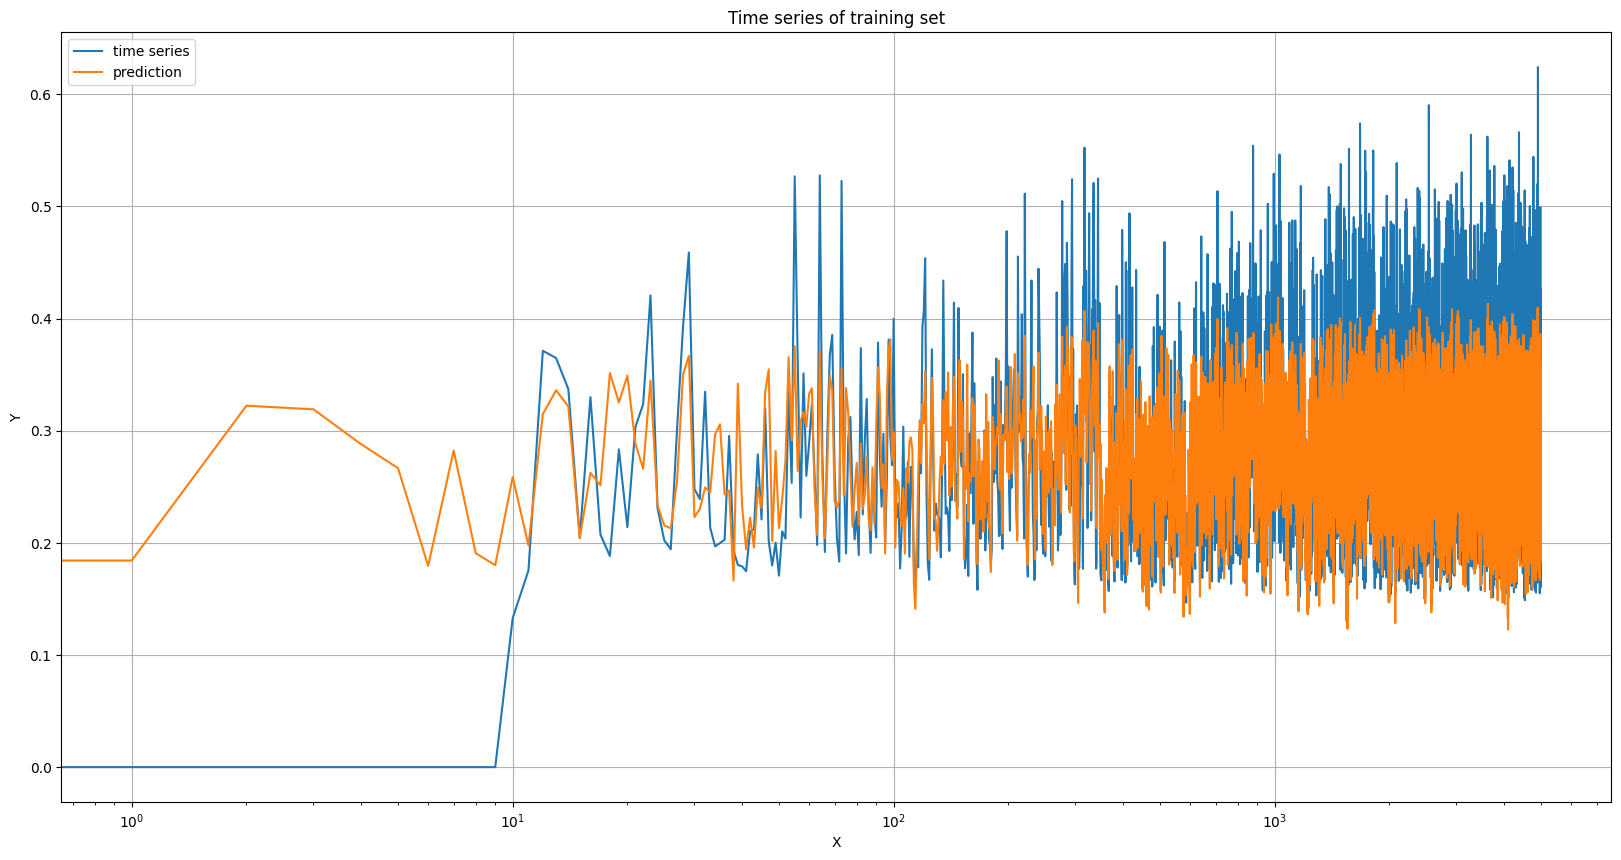

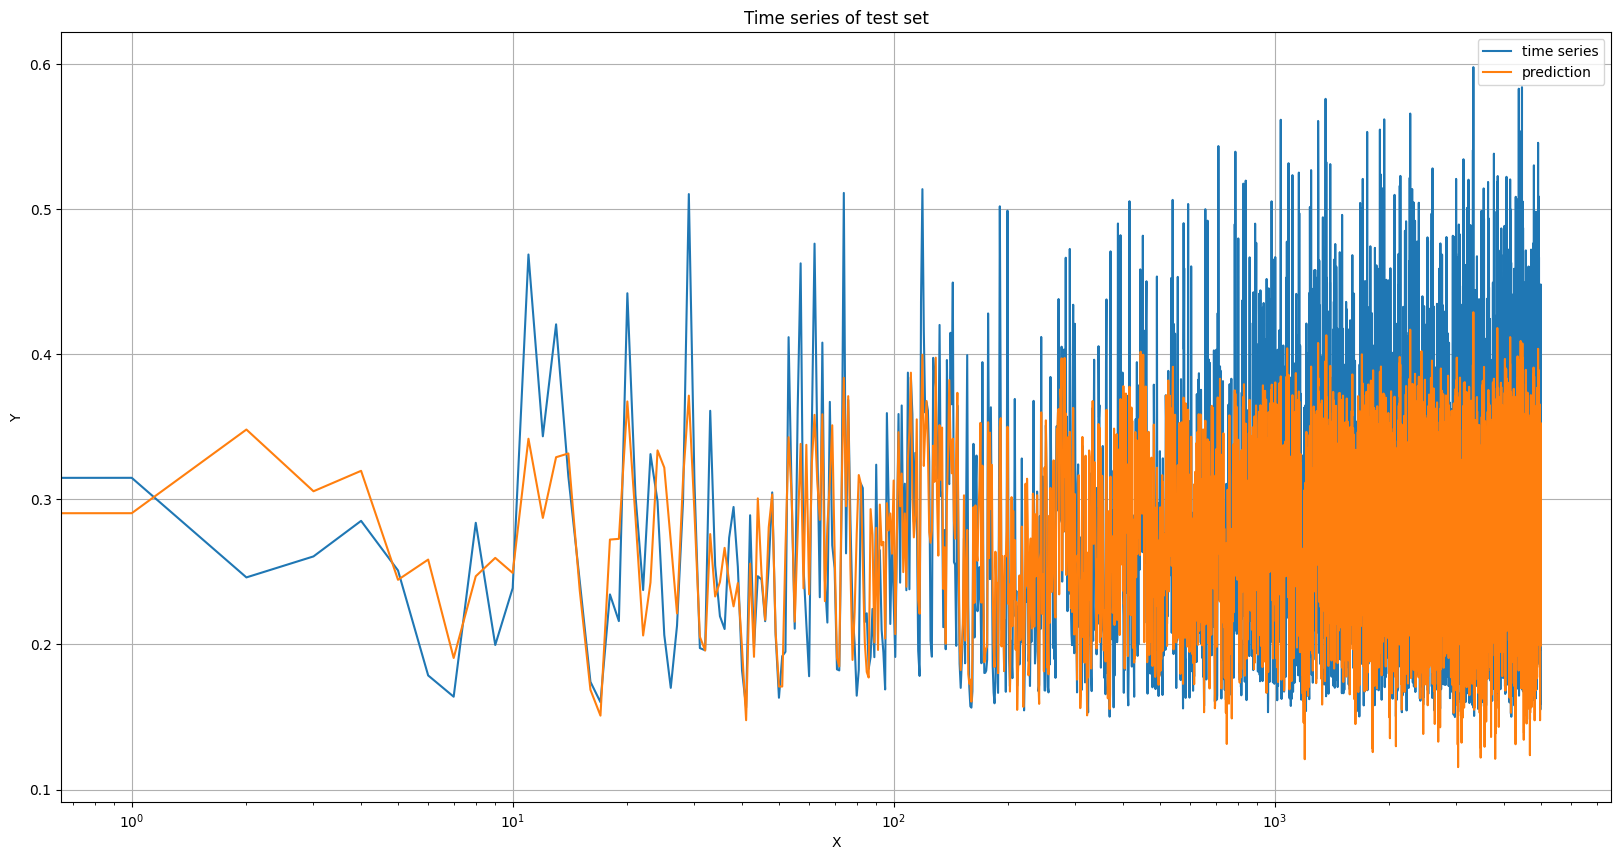

In [9]:
esn_save_name = 'esn_narma10'

narma10_tr_loss, narma10_ts_loss, narma10_tr_preds, narma10_ts_preds = gridsearch(
    configs=dict(
        hidden_size=[50, 100, 200],
        input_scaling=[0.1, 0.5],
        spectral_radius=[0.8, 0.9],
        leakage_rate=[0.2, 0.8], 
        sparsity=[0.9, 0.5],
        reg=[1e-5],
        transient=[100, 150]
    ),
    TR=(TR_X_narma10, TR_Y_narma10),
    TS=(TS_X_narma10, TS_Y_narma10),
    vl_tr_size=4000,
    attempts_for_config=5,
    save_name=esn_save_name,
)

general_plot(TR_Y_narma10.reshape(-1), narma10_tr_preds, TS_Y_narma10.reshape(-1), narma10_ts_preds, save_name=esn_save_name)

# Bonus track 1 - Mackey-glass 17 task

Mackey-glass 17 task dataset loading and split in train and test set.

In [10]:
tr_size = 5000

with open(f'MG17.csv') as file:
    data = file.read().split('\n')[:-1][0]
    data = np.array([float(r) for r in data.split(',')])
    TR_mg17 = data[:tr_size]
    TS_mg17 = data[tr_size:]

TR_X_mg17 = TR_mg17[:-1].reshape(-1, 1, 1)
TR_Y_mg17 = TR_mg17[1:].reshape(-1, 1)
TS_X_mg17 = TS_mg17[:-1].reshape(-1, 1, 1)
TS_Y_mg17 = TS_mg17[1:].reshape(-1, 1)

TR_X_mg17.shape, TR_Y_mg17.shape, TS_X_mg17.shape, TS_Y_mg17.shape

((4999, 1, 1), (4999, 1), (4999, 1, 1), (4999, 1))

ESN gridsearch and results.

  0%|          | 0/96 [00:00<?, ?it/s]

1/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.9, 'reg': 1e-05, 'transient': 100} with loss 0.00044145847232827695
2/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.9, 'reg': 1e-05, 'transient': 150} with loss 0.0004742267358298851
3/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.5, 'reg': 1e-05, 'transient': 100} with loss 0.0008912573159093071
4/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.5, 'reg': 1e-05, 'transient': 150} with loss 0.0007864804007145908
5/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.8, 'sparsity': 0.9, 'reg': 1e-05, 'transient': 100} with loss 6.45721771570357e-06
6/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1

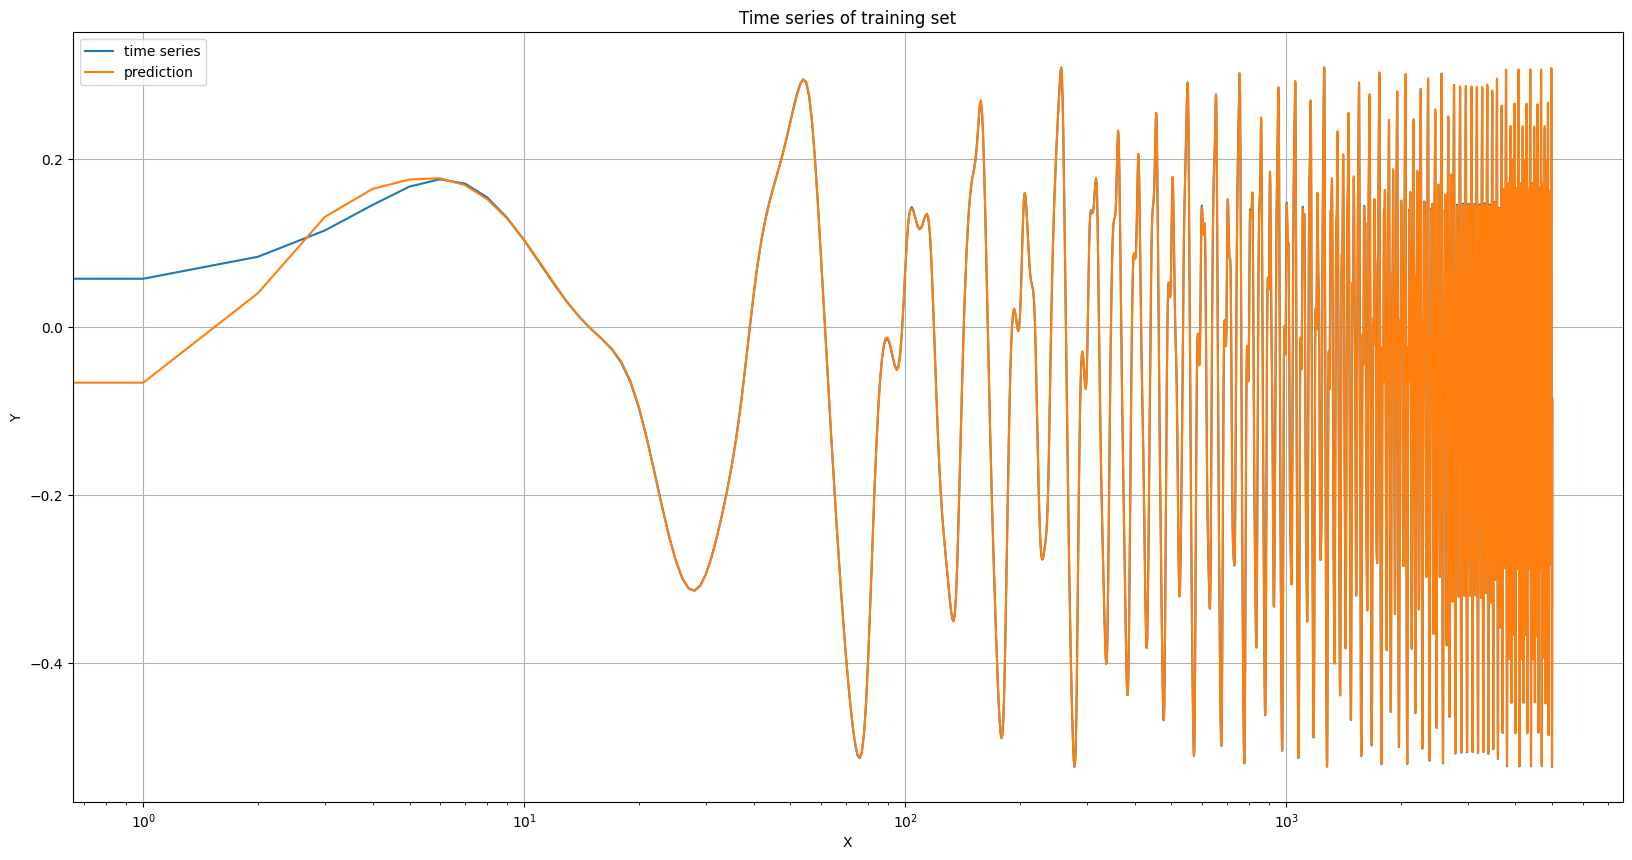

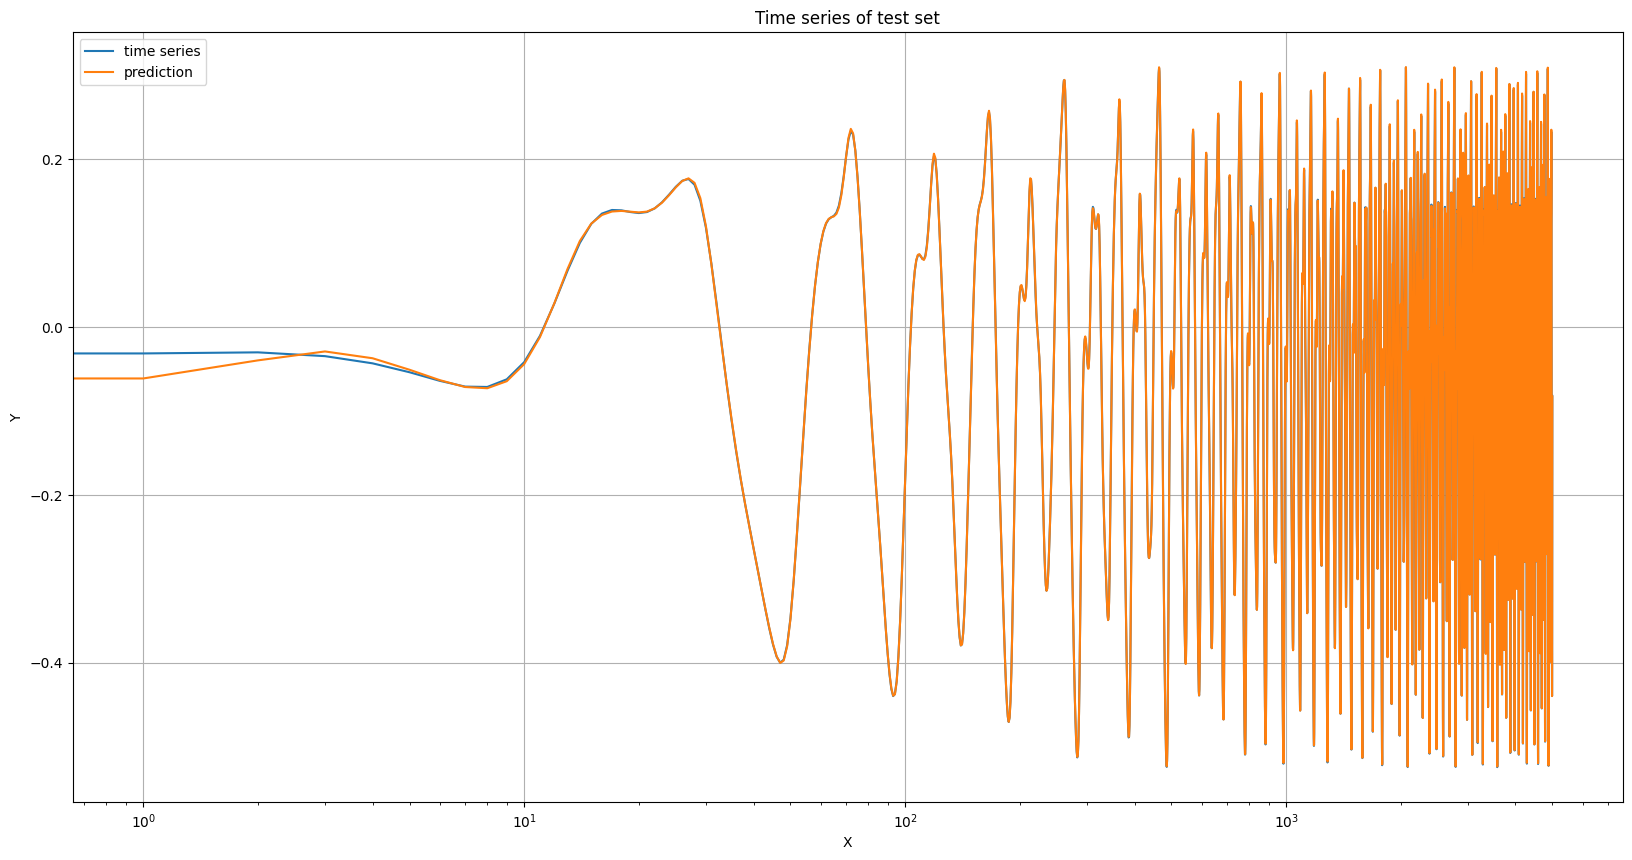

In [11]:
esn_save_name = 'esn_mg17'

mg17_tr_loss, mg17_ts_loss, mg17_tr_preds, mg17_ts_preds = gridsearch(
    configs=dict(
        hidden_size=[50, 100, 200],
        input_scaling=[0.1, 0.5],
        spectral_radius=[0.8, 0.9],
        leakage_rate=[0.2, 0.8], 
        sparsity=[0.9, 0.5],
        reg=[1e-5],
        transient=[100, 150]
    ),
    TR=(TR_X_mg17, TR_Y_mg17),
    TS=(TS_X_mg17, TS_Y_mg17),
    vl_tr_size=4000,
    attempts_for_config=5,
    save_name=esn_save_name,
)

general_plot(TR_Y_mg17.reshape(-1), mg17_tr_preds, TS_Y_mg17.reshape(-1), mg17_ts_preds, save_name=esn_save_name)